# Comparing the CSI-RS results with Matlab
Compare the results of this notebook with the Matlab file ``CSI-RS.mlx`` in
the ``MatlabFiles`` directory.

The ".mat" files in the ``MatlabFiles`` directory were created by running the ``CSI-RS.mlx`` file. If you want to recreate these files, follow the instructions in the Matlab file. [Here](MatlabFiles/CSI-RS.html) is the execution results of this code in Matlab.

In [1]:
import numpy as np
import scipy.io

matlabPath = "./MatlabFiles"

from neoradium import Carrier, CsiRsConfig, CsiRsSet, CdlChannel, Grid, AntennaPanel
from neoradium.utils import getNmse

## Carrier Configuration
Create an instance of `Carrier` object. We use 15KHz subcarrier spacing, with a single Bandwidth Part starting at Resource Block 0, and 25 total Resource Blocks. We then call the `print` method to show the carrier information.

In [2]:
carrier = Carrier(startRb=0, numRbs=25, spacing=15, nFFT=2048)

carrier.print()


Carrier Properties:
  Cell Id:               1
  Bandwidth Parts:       1
  Active Bandwidth Part: 0
  Bandwidth Part 0:
    Resource Blocks:    25 RBs starting at 0 (300 subcarriers)
    Subcarrier Spacing: 15 KHz
    CP Type:            normal
    bandwidth:          4.5 MHz
    symbolsPerSlot:     14
    slotsPerSubFrame:   1
    nFFT:               2048
    frameNo:            0
    slotNo:             0



## CSI-RS Configuration
Now we create a CSI-RS condiguration object ``CsiRsConfig`` with a two CSI-RS resource sets: One for Non-Zero Power (NZP) and one for Zero-Power CSI-RS resoueces. The following code then creates one CSI-RS resource in each one of the two CSI-RS resource sets.

The ``print`` function is then called to print all the configuration properties in the ``CsiRsConfig`` object. 

Please note that to test the timing functionality of CSI-RS implementation, we are setting the ``period`` to 5, and ``offset`` to one. This means that the CSI-RS allocation starts at slot number one and continues every other 5 slots. We also set the current slot number of our ``Carrier`` object to 1 so that the first time a grid is populated the results will have CSI-RS data.

In [3]:
# Set current slot number in the carrier object to 1. This is to test the CSI-RS 'offset' functionality.
# Note that the CSI-RS power `powerDb` is 0 db by default.
bwp = carrier.bwps[0]
carrier.slotNo = 1
csiRsConfig = CsiRsConfig([CsiRsSet("NZP", bwp, symbols=[1], numPorts=2, freqMap='001000', period=5, offset=1),
                           CsiRsSet("ZP", bwp, symbols=[6], numPorts=4, freqMap='000100', period=5, offset=1)])
csiRsConfig.print()






CSI-RS Configuration: (2 Resource Sets)
  CSI-RS Resource Set:(1 NZP Resources)
    Resource Set ID: 0
    Resource Type: periodic
    Resource Blocks: 25 RBs starting at 0
    Slot Period: 5
    Bandwidth Part:
      Resource Blocks:    25 RBs starting at 0 (300 subcarriers)
      Subcarrier Spacing: 15 KHz
      CP Type:            normal
      bandwidth:          4.5 MHz
      symbolsPerSlot:     14
      slotsPerSubFrame:   1
      nFFT:               2048
      frameNo:            0
      slotNo:             1
    CSI-RS:
      resourceId: 0
      numPorts: 2
      cdmSize: 2 (fd-CDM2)
      density: 1
      RE Indexes: 6
      Symbol Indexes: 1
      Table Row: 3
      Slot Offset: 1
      Power: 0 db
      scramblingID: 0
  CSI-RS Resource Set:(1 ZP Resources)
    Resource Set ID: 0
    Resource Type: periodic
    Resource Blocks: 25 RBs starting at 0
    Slot Period: 5
    Bandwidth Part:
      Resource Blocks:    25 RBs starting at 0 (300 subcarriers)
      Subcarrier Spacing

## Create a resource grid and populate it with CSI-RS
Here we use the ``createGrid`` method of the bandwidth part object ``bwp`` to create a resource grid with the number of ports set based on the CSI-RS configuration.

Then we can use the ``populateGrid`` method of the ``CsiRsConfig`` object to poulate the grid with CSI-RS information. The ``getStats`` function of the ``Grid`` object returns a dictionary containing some statistics about the resource grid allocation.

After printing the statistics, the ``drawMap`` method is called to visualize the allocation of CSI-RS resources for all 4 ports of the grid.


Resource Grid Properties:
  startRb: 0
  numRbs: 25
  numSlots: 1
  Data Contents: DATA
  Size: 16800
  Shape: (4, 14, 300)
  Bandwidth Part:
    Resource Blocks:    25 RBs starting at 0 (300 subcarriers)
    Subcarrier Spacing: 15 KHz
    CP Type:            normal
    bandwidth:          4.5 MHz
    symbolsPerSlot:     14
    slotsPerSubFrame:   1
    nFFT:               2048
    frameNo:            0
    slotNo:             1

Grid Allocation Stats:
  GridSize: 16800
  UNASSIGNED: 16500
  CSIRS_NZP: 100
  CSIRS_ZP: 200


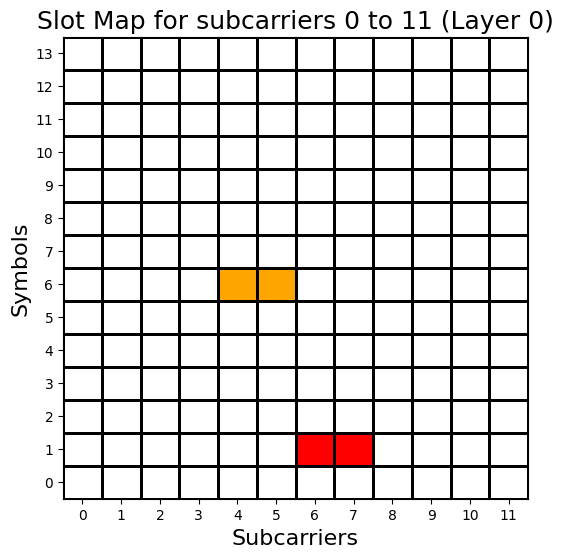

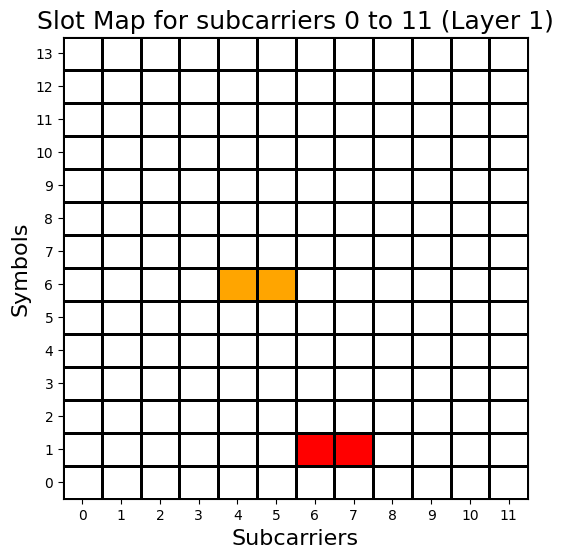

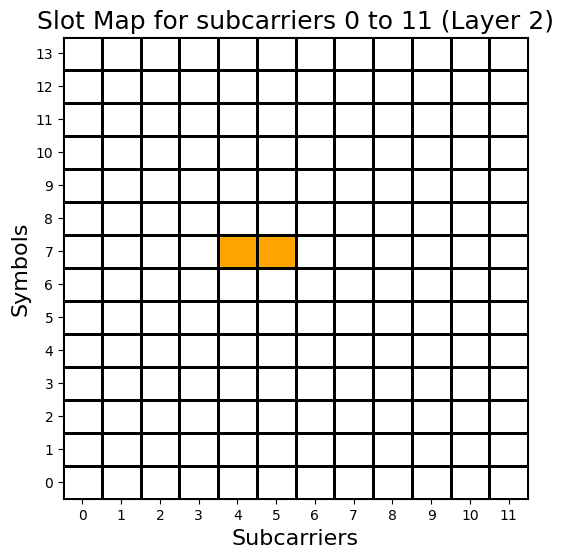

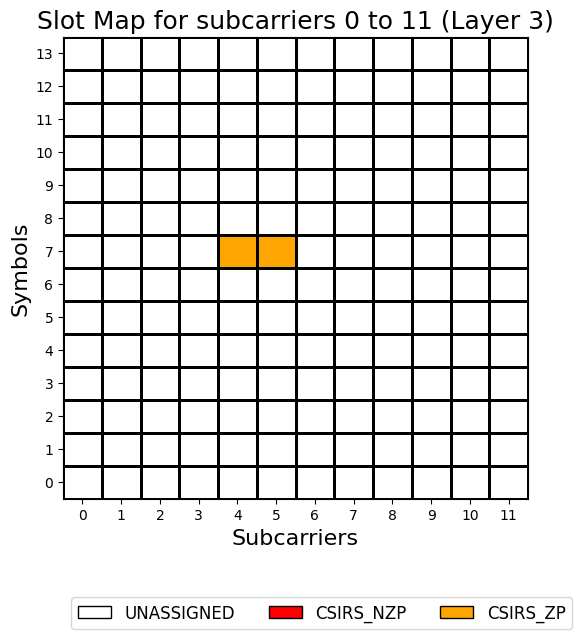

In [4]:
grid = bwp.createGrid(csiRsConfig.numPorts)
grid.print()

csiRsConfig.populateGrid(grid)

gridStats = grid.getStats()
print("Grid Allocation Stats:")
for key, value in gridStats.items():
    print("  %s: %d"%(key, value))
    
grid.drawMap(ports=[0,1,2,3])

## Comparing CSI-RS values
Now we want to compare the CSI-RS values generated by our `CsiRsConfig` object with Matlab's results. The ``getReValues`` method of the ``Grid`` class returns all the complex values allocated for the specified type. We call this function 2 times with ``CSIRS_ZP``, and ``CSIRS_NZP`` to get the allocated values for Zero-Power and Non-Zero Power CSI-RS resources correspondingly.

We then concatenates these values to get all CSI-RS resources in a single array ``csirsSymbols``.

The results are compared with the values generated by Matlab's ``nrCSIRS`` function in the 5G toolkit.

In [5]:
csirsZpSymbols = grid.getReValues("CSIRS_ZP")     # These are all Zeros (ZP: Zero Power)
csirsNzpSymbols = grid.getReValues("CSIRS_NZP")
csirsSymbols = np.concatenate((csirsZpSymbols,csirsNzpSymbols))

# Load Matlab-generated CSI-RS symbols:
csirsSymbolsMatlab = scipy.io.loadmat(matlabPath + '/csirsSym.mat')['csirsSym'].T.flatten()
maxDiff = np.abs(csirsSymbols-csirsSymbolsMatlab).max()
assert maxDiff<1e-10, "MISMATCH WITH MATLAB!!! (max Diff: %f)"%(maxDiff)

# Print the first 10 CSI-RS NZP Symbols:
print("CSI-RS NZP Values:\n",np.round(csirsSymbols[200:210],4))
print("Matlab-Generated CSI-RS NZP Values:\n",np.round(csirsSymbolsMatlab[200:210],4))
print("Maximum Difference:", maxDiff)

CSI-RS NZP Values:
 [ 0.7071+0.7071j -0.7071+0.7071j  0.7071+0.7071j  0.7071+0.7071j
  0.7071+0.7071j  0.7071+0.7071j  0.7071-0.7071j -0.7071+0.7071j
  0.7071+0.7071j  0.7071+0.7071j]
Matlab-Generated CSI-RS NZP Values:
 [ 0.7071+0.7071j -0.7071+0.7071j  0.7071+0.7071j  0.7071+0.7071j
  0.7071+0.7071j  0.7071+0.7071j  0.7071-0.7071j -0.7071+0.7071j
  0.7071+0.7071j  0.7071+0.7071j]
Maximum Difference: 1.5700924586837752e-16


We can also compare the whole grid with the one grid created by Matlab's function ``nrResourceGrid``.

In [6]:
gridMatlab = scipy.io.loadmat(matlabPath + '/txGrid.mat')['txGrid']
gridMatlab = np.transpose(gridMatlab, (2,1,0)) # Matlab uses a different order
maxDiff = np.abs(gridMatlab-grid.grid).max()
assert maxDiff<1e-10, "MISMATCH WITH MATLAB!!! (max Diff: %f)"%(maxDiff)

# Print the first 10 Data Symbols:
print("Grid:\n", np.round(grid[0,:,127],4))
print("Matlab-Generated Grid:\n", np.round(gridMatlab[0,:,127],4))
print("Maximum Difference:", maxDiff)

Grid:
 [ 0.    +0.j     -0.7071-0.7071j  0.    +0.j      0.    +0.j
  0.    +0.j      0.    +0.j      0.    +0.j      0.    +0.j
  0.    +0.j      0.    +0.j      0.    +0.j      0.    +0.j
  0.    +0.j      0.    +0.j    ]
Matlab-Generated Grid:
 [ 0.    +0.j     -0.7071-0.7071j  0.    +0.j      0.    +0.j
  0.    +0.j      0.    +0.j      0.    +0.j      0.    +0.j
  0.    +0.j      0.    +0.j      0.    +0.j      0.    +0.j
  0.    +0.j      0.    +0.j    ]
Maximum Difference: 1.5700924586837752e-16


## OFDM Modulation
To ger a time-domain Now we want to compare the ``ofdmModulate`` method of the ``Grid`` class. This waveform is then compared with the one created by Matlab's ``nrOFDMModulate`` function.

In [7]:
waveForm = grid.ofdmModulate()

waveformMatlab = scipy.io.loadmat(matlabPath + '/txWaveform.mat')['txWaveform'].T
maxDiff = np.abs(waveForm[:]-waveformMatlab).max()
assert maxDiff<1e-10, "MISMATCH WITH MATLAB!!! (max Diff: %f)"%(maxDiff)

# print the first 10 samples of the waveForm for first TX antenna
print("Waveform Shape:", waveForm.shape)
print("Waveform Data:\n", np.round(waveForm[0,3000:3010],4))
print("Matlab-Generated Waveform Data:\n", np.round(waveformMatlab[0,3000:3010],4))
print("Maximum Difference:", maxDiff)


Waveform Shape: (4, 30720)
Waveform Data:
 [0.0017-0.0022j 0.0027-0.0026j 0.0038-0.0027j 0.0048-0.0026j
 0.0054-0.0023j 0.0055-0.0019j 0.0051-0.0015j 0.0042-0.0013j
 0.0028-0.0012j 0.0012-0.0013j]
Matlab-Generated Waveform Data:
 [0.0017-0.0022j 0.0027-0.0026j 0.0038-0.0027j 0.0048-0.0026j
 0.0054-0.0023j 0.0055-0.0019j 0.0051-0.0015j 0.0042-0.0013j
 0.0028-0.0012j 0.0012-0.0013j]
Maximum Difference: 3.878959614448864e-18


## CDL Channel Model
Now we want to create a CDL Channel object (``CdlChannel``) and apply it to the time-domain waveform. 

Since CDL is a statistical model, there is always a randomness with the way the phases are initialized and the way rays are coupled. The ``getMatlabRandomInit`` helper function can be used to create the same random initial phases and ray couplings that are generated by the Matlab code.

**Note 2:**
The NeoRadium's implementation of FIR filters used by the CDL channel is slightly different from Matlab. To compensate for this difference we need to modify the ``stopBandAttenuation`` parameter. See the documentation of ``ChannelFilter`` class for more information.

In [8]:
cdlModel = 'D'
seed = 123
phiInit, coupling = CdlChannel.getMatlabRandomInit(cdlModel, seed)

# Create the channel model
channel = CdlChannel(bwp, 'D', delaySpread=10, carrierFreq=4e9, dopplerShift=10,
                     initialPhases = phiInit, rayCoupling = coupling,
                     txAntenna = AntennaPanel([1,2], polarization="x", matlabOrder=True),
                     rxAntenna = AntennaPanel([1,2], polarization="+", matlabOrder=True),
                     txOrientation = [10, 20, 30],
                     angleScaling = ([130,70,80,110], [5,11,3,3]),
                     stopBandAtten = 70)
channel.print()


CDL-D Channel Properties:
  carrierFreq:          4 GHz
  normalizeGains:       True
  normalizeOutput:      True
  txDir:                Downlink
  filterLen:            16 samples
  delayQuantSize:       64
  stopBandAtten:        70 db
  dopplerShift:         10 Hz
  coherenceTime:        0.042314218766081726 Sec.
  delaySpread:          10 ns
  ueDirAZ:              0.0°, 90.0°
  Angle Scaling:
    Means:               130° 70° 80° 110°
    RMS Spreads:         5° 11° 3° 3°
  Cross Pol. Power:     11 db
  angleSpreads:         5° 8° 3° 3°
  TX Antenna:
    Total Elements:     4
    spacing:            0.5𝜆, 0.5𝜆
    shape:              1 rows x 2 columns
    polarization:       x
  RX Antenna:
    Total Elements:     4
    spacing:            0.5𝜆, 0.5𝜆
    shape:              1 rows x 2 columns
    polarization:       +
    Orientation (𝛼,𝛃,𝛄): 0° 0° 0°
  hasLOS:               True
  LOS Path:
    Delay (ns):         0.00000
    Power (db):         -0.20000
    AOD (Deg):        

## Comparing the channel matrix with Matlab
NeoRadium supports different methods for creating a channel matrix from a CDL channel model. The method that matches Matlab's ``nrPerfectChannelEstimate`` function is called ``TimeDomain2``. Note that this is **NOT** the default method used by NeoRadium. See the documentation of ``getChannelMatrix`` method for more information. 

In [9]:
hActual = channel.getChannelMatrix()

# Compare with Matlabmatlab results
hActualMatlab = np.transpose(scipy.io.loadmat(matlabPath + '/H_actual.mat')['H_actual'], (1,0,2,3))
nmse = getNmse(hActual,hActualMatlab)
assert nmse<1e-3, "MISMATCH WITH MATLAB!!! (NMSE: %f)"%(nmse)

print("hActual Shape:", hActual.shape)
print("NMSE:         ", nmse)

print("Channel:\n", np.round(hActual[:,0,0,0],4))
print("Matlab-Generated Channel:\n", np.round(hActualMatlab[:,0,0,0],4))


hActual Shape: (14, 300, 4, 4)
NMSE:          8.414875703187369e-05
Channel:
 [-0.0038-0.0173j -0.0038-0.0173j -0.0037-0.0173j -0.0037-0.0172j
 -0.0036-0.0172j -0.0036-0.0172j -0.0036-0.0172j -0.0035-0.0172j
 -0.0035-0.0172j -0.0034-0.0171j -0.0034-0.0171j -0.0034-0.0171j
 -0.0033-0.0171j -0.0033-0.0171j]
Matlab-Generated Channel:
 [-0.0038-0.0173j -0.0038-0.0173j -0.0038-0.0173j -0.0038-0.0173j
 -0.0038-0.0173j -0.0038-0.0173j -0.0034-0.0171j -0.0034-0.0171j
 -0.0034-0.0171j -0.0034-0.0171j -0.0034-0.0171j -0.0034-0.0171j
 -0.0034-0.0171j -0.0034-0.0171j]


## Applying the channel to the waveform
Now we can apply our CDL channel to the waveform. Since the channel has some propagation delay, to make sure the whole waveform goes through the channel we need to append zeros to the end of the waveform. 

The number of these zero paddings is equal to the channel delay which can be obtained using the ``getMaxDelay`` function.

The ``applyToSignal`` method is then used to apply the channel to the waveform. It returns the waveform transformed by the channel (``rxWaveform``).

This ``rxWaveform`` is then compared the waveform created by Matlab.

In [10]:
maxDelay = channel.getMaxDelay()
print("Max. Channel Delay (Samples):",maxDelay)
# Append to the waveForm before passing it through the channel
txWaveform = waveForm.pad(maxDelay)

# Now apply the channel to the waveform
rxWaveform = channel.applyToSignal(txWaveform)

# Compare results with Matlab:
rxWaveformMatlab = scipy.io.loadmat(matlabPath+'/rxWaveform.mat')['rxWaveform']
nmse = getNmse(rxWaveform[:].T, rxWaveformMatlab)
assert nmse<1e-3, "MISMATCH WITH MATLAB!!! (NMSE: %f)"%(nmse)

# print the first 10 samples of the waveForm for first TX antenna
print("RX Waveform Sahpe:", rxWaveform.shape)
print("RX Waveform Data:\n", rxWaveform[0,3000:3010])
print("Matlab-Generated Waveform Data:\n", rxWaveformMatlab[3000:3010,0])
print("NMSE:", nmse)


Max. Channel Delay (Samples): 11
RX Waveform Sahpe: (4, 30731)
RX Waveform Data:
 [ 9.28952127e-05-2.14999676e-05j  8.57060514e-05-2.00952163e-05j
  7.42433156e-05-1.57109998e-05j  5.84631269e-05-1.01630403e-05j
  3.89446995e-05-5.38726734e-06j  1.68653643e-05-3.09457972e-06j
 -6.14293105e-06-4.46025641e-06j -2.82289087e-05-9.89854387e-06j
 -4.76034145e-05-1.89598598e-05j -6.28120056e-05-3.03690684e-05j]
Matlab-Generated Waveform Data:
 [ 9.28855165e-05-2.17075417e-05j  8.57030299e-05-2.02737737e-05j
  7.42472190e-05-1.58492708e-05j  5.84693723e-05-1.02529180e-05j
  3.89449786e-05-5.42511597e-06j  1.68494399e-05-3.08190658e-06j
 -6.18506471e-06-4.40357151e-06j -2.83048719e-05-9.80838148e-06j
 -4.77166484e-05-1.88491000e-05j -6.29606231e-05-3.02508414e-05j]
NMSE: 8.678362707587525e-06


## Adding AWGN
Again to make sure we have deterministic results, instead of generating random noise we read the noise values from the file ``noise.mat`` which was generated by Matlab . Now we have the noisy received time-domain waveform ``noisyWaveForm``.

In [11]:
# Add noise: (SNR=50 dB)
noise = scipy.io.loadmat(matlabPath+'/noise.mat')['noise']
print("Noise Varriance:", noise.var(), "(%.2f dB)"%(10*np.log10(1/(noise.var()*channel.nrNt[0]*bwp.nFFT))) )
noisyWaveForm = rxWaveform.addNoise(noise=noise.T)
noisyWaveForm.shape

Noise Varriance: 1.2203149233307698e-09 (50.00 dB)


(4, 30731)

## Synchronization
To synchronize the received noise waveform, we need to calculate the offset value which is the number of samples to skip at the begining of the received signal. This can be obtained directly from the channel model using the ``getTimingOffset`` method. 

But in practice, the channel information is not available and we need to estimate this value. The method ``estimateTimingOffset`` of the ``Grid`` class does exactly that.

The following code uses both method and compares the values.

In [12]:
# We can get channel delay from the channel (This is cheating because we don't know the channel)
chOffset = channel.getTimingOffset()
print("Channel Offset from the Channel Model:", chOffset)
bwp.slotNo = 1
# Or estimate the offset using a resource grid with NZP CSI-RS and the recived signal
rxCsiRsConfig = CsiRsConfig([CsiRsSet("NZP", bwp, symbols=[1], numPorts=2, freqMap='001000', period=5, offset=1)])
csiRsGrid = bwp.createGrid(rxCsiRsConfig.numPorts)
rxCsiRsConfig.populateGrid(csiRsGrid)
offset = csiRsGrid.estimateTimingOffset(noisyWaveForm)
print("Estimated Offset:", offset)

# Now apply the offset to the received waveform
syncedWaveForm = noisyWaveForm.sync(offset)


Channel Offset from the Channel Model: 7
Estimated Offset: 7


## OFDM Demodulation
Now we can use the ``ofdmDemodulate`` method of the ``Grid`` class to calculate the received grid ``rxGrid`` in frequency domain. This results are then compared with the grid created by Matlab's ``nrOFDMDemodulate`` function.

In [13]:
rxGrid = Grid.ofdmDemodulate(bwp, syncedWaveForm)

# Compare results with Matlab:
rxGridMatlab = scipy.io.loadmat(matlabPath + '/rxGrid.mat')['rxGrid']
rxGridMatlab = np.transpose(rxGridMatlab, (2,1,0)) # Matlab uses a different order
nmse = getNmse(rxGridMatlab, rxGrid.grid)
assert nmse<1e-3, "MISMATCH WITH MATLAB!!! (nmse: %f)"%(nmse)

# Print the first 10 Data Symbols:
print("RX Grid Sahpe:", rxGrid.shape)
print("RX Grid:\n", rxGrid[0,:,120])
print("Matlab-Generated RX Grid:\n", rxGridMatlab[0,:,120])
print("NMSE:", nmse)


RX Grid Sahpe: (4, 14, 300)
RX Grid:
 [-2.61575139e-03-0.00175339j -1.06114113e-03-0.0013182j
 -8.51931543e-05-0.00099349j  8.12506622e-04+0.00099399j
  4.40631448e-04-0.00146395j -1.26437220e-03+0.0011728j
 -9.79090970e-04+0.00045581j -3.08299457e-04+0.00019759j
  8.56087026e-04-0.00012872j -1.62260526e-03-0.00062589j
  1.10153725e-03+0.00029551j -5.56870049e-04-0.00037998j
  3.54244624e-04-0.00114511j -7.91488916e-04-0.00068177j]
Matlab-Generated RX Grid:
 [-2.61575139e-03-0.00175339j -1.06114113e-03-0.0013182j
 -8.51931543e-05-0.00099349j  8.12506622e-04+0.00099399j
  4.40631448e-04-0.00146395j -1.26437220e-03+0.0011728j
 -9.79090970e-04+0.00045581j -3.08299457e-04+0.00019759j
  8.56087026e-04-0.00012872j -1.62260526e-03-0.00062589j
  1.10153725e-03+0.00029551j -5.56870049e-04-0.00037998j
  3.54244624e-04-0.00114511j -7.91488916e-04-0.00068177j]
NMSE: 6.617947551450802e-06


## Channel Estimation
Now we use the ``estimateChannelLS`` method of the ``Grid`` class to estimate the channel using the received grid and the CSI-RS information. We then compare this estimated channel with the actual channel obtained above.

In [14]:
# Least Squares Channel Estimation
hEst, _ = rxGrid.estimateChannelLS(rxCsiRsConfig) 

hActual = hActual[:,:,:,:2] # Ignore the port related to ZP CSI-RS
print("Min Absolute Error:", np.abs(hActual-hEst).min())
print("Max Absolute Error:", np.abs(hActual-hEst).max())
print("Mean Absolute Error:", np.abs(hActual-hEst).mean())
print("MSE:", np.square(np.abs(hActual-hEst)).mean())
print("NMSE:", getNmse(hActual,hEst))

# Print symbol values for the first subcarrier for the first pair of antennas
print("Actual Channel:\n", hActual[:,0,0,0])
print("Estimated Channel:\n", hEst[:,0,0,0])


Min Absolute Error: 2.436471815433792e-06
Max Absolute Error: 0.0028062738208536357
Mean Absolute Error: 0.0008498159738921739
MSE: 9.255972645727842e-07
NMSE: 0.0031038948847244203
Actual Channel:
 [-0.00381751-0.01728997j -0.00377508-0.01727434j -0.00373278-0.01725857j
 -0.00369059-0.01724268j -0.00364851-0.01722666j -0.00360655-0.01721052j
 -0.00356471-0.01719424j -0.00352268-0.01717773j -0.00348108-0.0171612j
 -0.00343959-0.01714455j -0.00339822-0.01712778j -0.00335697-0.01711088j
 -0.00331584-0.01709387j -0.00327483-0.01707672j]
Estimated Channel:
 [-0.00462992-0.01794335j -0.00462992-0.01794335j -0.00462992-0.01794335j
 -0.00462992-0.01794335j -0.00462992-0.01794335j -0.00462992-0.01794335j
 -0.00462992-0.01794335j -0.00462992-0.01794335j -0.00462992-0.01794335j
 -0.00462992-0.01794335j -0.00462992-0.01794335j -0.00462992-0.01794335j
 -0.00462992-0.01794335j -0.00462992-0.01794335j]


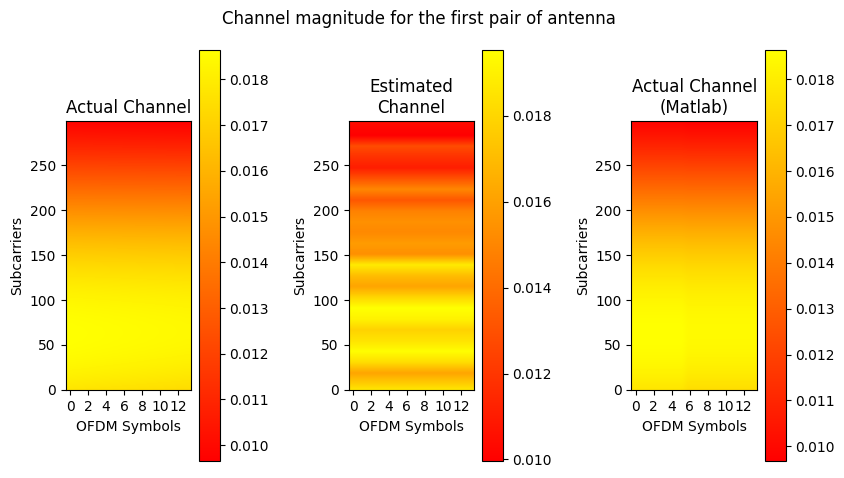

In [15]:
import matplotlib.pyplot as plt

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=[8,5])
fig.tight_layout()

fig.suptitle('Channel magnitude for the first pair of antenna')

hm1 = ax1.imshow(np.abs(hActual[:,:,0,0].T), cmap='autumn', aspect=.1, origin='lower')
ax1.set_title("Actual Channel")
ax1.set_xlabel("OFDM Symbols")
ax1.set_ylabel("Subcarriers")
ax1.set_xticks(range(0,14,2))
fig.colorbar(hm1, ax=ax1)

hm2 = ax2.imshow(np.abs(hEst[:,:,0,0].T), cmap='autumn', aspect=.1, origin='lower')
ax2.set_title("Estimated\nChannel")
ax2.set_xlabel("OFDM Symbols")
ax2.set_ylabel("Subcarriers")
ax2.set_xticks(range(0,14,2))
fig.colorbar(hm2, ax=ax2)

hm3 = ax3.imshow(np.abs(hActualMatlab[:,:,0,0].T), cmap='autumn', aspect=.1, origin='lower')
ax3.set_title("Actual Channel\n(Matlab)")
ax3.set_xlabel("OFDM Symbols")
ax3.set_ylabel("Subcarriers")
ax3.set_xticks(range(0,14,2))
fig.colorbar(hm3, ax=ax3)

fig.subplots_adjust(top=.9, wspace=.8)

plt.show()


# Side Note:
If you look at the Actual Channel from MATLAB, you can see that it’s not completely smooth along the symbols of the slot.